This code is heavely based on the code by Greg Kamrdt found here: https://github.com/gkamradt/LLMTest_NeedleInAHaystack

Main differences:
1. Greg's code uses Langchain to run the prompts of the retrieval and the evaluation, while I use directly the GPT-4 API.
2. My test covers a sub-set of Greg's test: This notebook focuses in the area the proved to be weaker in the results in GPT-4. I am excluding the 'good' areas as per Greg's test.

In [1]:
import os
import tiktoken
import glob
import json
import numpy as np
import time

from openai import OpenAI

import uuid
import re


In [2]:
enc = tiktoken.encoding_for_model("gpt-4-1106-preview")

In [3]:
# INITIALIZE GPT 4
api_key = "" 
org_key = "" 

apikey_path = "../apikeys/api_openai.key"
orgKey_path = "../apikeys/api_openai_org.key"

with open(apikey_path, 'r') as file:
    api_key = file.read().strip()

with open(orgKey_path, 'r') as file:
    org_key = file.read().strip()

In [4]:
openai_client = OpenAI(api_key=api_key, organization=org_key)

In [5]:
txt_files_path = "LLMTest_NeedleInAHaystack/PaulGrahamEssays"

In [6]:
model = "gpt-4-1106-preview"

def GPT(model, system_prompt, user_prompt):
    result = "" 
    prompt_tokens = 0 
    completion_tokens = 0
    total_tokens = 0

    try:
        response = openai_client.chat.completions.create(
            messages=[{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}],
            temperature=0,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None,
            model=model,
        )     
        #result =  response["choices"][0]["message"]["content"].strip()
        result = response.choices[0].message.content 
        prompt_tokens = response.usage.prompt_tokens
        completion_tokens = response.usage.completion_tokens
        total_tokens = response.usage.total_tokens

        return result, prompt_tokens, completion_tokens, total_tokens
    
    except Exception as e:
        print(f"An error occurred on GPT: {e}")
        return None, 0, 0, 0

In [7]:
def read_files(directory):
    context = ""
    for file in glob.glob(directory):
        with open(file, 'r') as f:
            context += f.read()
    return context

In [8]:
def getContext(context_length=0):
    context = read_files(f"{txt_files_path}/*.txt")
    context = context.replace("\n", " ") 

    if context_length == 0:
        return context 
    else: 
        tokens = enc.encode(context)
        
        selected_tokens = tokens[:context_length] 
        selected_tokenized_text = enc.decode(selected_tokens)
        context = ''.join(selected_tokenized_text) 
        return context 


In [9]:
def pick_section(context, depth_percent, qty_sentences): 

    # Split the context into sentences
    sentences = re.split(r'(?<=[.!?]) +', context)

    # Calculate the starting index
    total_sentences = len(sentences)
    start_index = int(total_sentences * (depth_percent / 100))

    # Adjust the start index if it goes beyond the context's length
    start_index = min(start_index, total_sentences - qty_sentences)

    # Extract the section
    section = sentences[start_index:start_index + qty_sentences]

    return "".join(section)

In [10]:
def generate_context(context_length, depth_percent, qty_sentences=1): 
    context = getContext(context_length) 
    section = pick_section(context, depth_percent, qty_sentences)
    return context, section 

In [11]:
def result_exists(results, context_length, depth_percent, qty_sentences, version):
    """
    Checks to see if a result has already been evaluated or not
    """
    conditions_met = []
    for result in results:
        context_length_met = result['context_length'] == context_length
        depth_percent_met = result['depth_percent'] == depth_percent
        qty_sentences_met = result['qty_sentences'] == qty_sentences
        version_met = result.get('version', 1) == version
        conditions_met.append(context_length_met and depth_percent_met and qty_sentences_met and version_met)
        
    return any(conditions_met)

In [12]:
def evaluate_response(response, needle, question_to_ask): 
    accuracy_criteria = {
        "Accuracy criteria": """
        Score 1: The answer is completely unrelated to the reference.
        Score 3: The answer has minor relevance but does not align with the reference.
        Score 5: The answer has moderate relevance but contains inaccuracies.
        Score 7: The answer aligns with the reference but has minor errors or omissions.
        Score 10: The answer is completely accurate and aligns perfectly with the reference.      
        """
    } 

    system_prompt = "You are a helpful AI bot that answers questions for a user. Read the given [CONTEXT], [QUESTION] and [RESPONSE], then rate the [RESPONSE] using the [ACCURACY_CRITERIA]. Keep your response short and direct."

    user_prompt = f"""
        Given the following [CONTEXT], [QUESTION], and [RESPONSE], evaluate the response based on the specified [ACCURACY_CRITERIA] and provide a rating.

        [CONTEXT]
        {needle}

        [QUESTION]
        {question_to_ask}

        [RESPONSE]
        {response}

        [ACCURACY_CRITERIA]
        {accuracy_criteria}

        Based on these criteria, please rate the response. Just give the score.

    """ 

    model = "gpt-4-1106-preview"
    model = "gpt-3.5-turbo"
    score, prompt_tokens, completion_tokens, total_tokens = GPT(model, system_prompt, user_prompt)

    return score, prompt_tokens, completion_tokens, total_tokens
    

In [13]:

question_to_ask = "" 

# This will produce a list of context lengths for each experiment iteration
context_lengths = np.round(np.linspace(60000, 120000, num=7, endpoint=True)).astype(int)

# This will product a list of document depths to place your random statement (needle) at.
# Suggestion: Try out different distributions (like a sigmoid) to test non-evenly space intervals
document_depth_percents = np.round(np.linspace(20, 80, num=7, endpoint=True)).astype(int)

print(context_lengths) 
print(document_depth_percents)

[ 60000  70000  80000  90000 100000 110000 120000]
[20 30 40 50 60 70 80]


In [14]:
# Change the version # if you would like to run the results multiple times.
# If you're just testing, then leave as version=1
results_version = 1
qty_sentences = 2

In [15]:
# The code will check to see if a context_length, depth percent and version number have already been checked yet

def qa_retrieval():
    # Run through each iteration of context_lengths and depths

    for context_length in context_lengths:
        for depth_percent in document_depth_percents: 

            try:
                with open('results_qa.json', 'r') as f:
                    results = json.load(f)
            except FileNotFoundError:
                results = []
                pass

            # Checks to see if you've already checked a length/percent/version.
            # This helps if the program stop running and you want to restart later
            if result_exists(results, context_length, depth_percent, qty_sentences, results_version ):
                continue

            context, section = generate_context(context_length, depth_percent, qty_sentences)

            # Generate the question_to_ask based on the section
            system_prompt = ""  
            user_prompt = f"Write a question for which the following text is the answer:\n\nAnswer: {section}\nQuestion:"

            model = "gpt-4-1106-preview" 
            model = "gpt-3.5-turbo"
            question_to_ask, prompt_tokens, completion_tokens, total_tokens = GPT(model, system_prompt, user_prompt)

            if total_tokens > 0: 

                system_prompt = "You are a helpful AI bot that answers questions for a user. Read the given [CONTEXT] and answer the given [QUESTION] based ONLY on the [CONTEXT]. Keep your response short and direct. Do not go outside of the [CONTEXT]."

                user_prompt = f"""
                    [CONTEXT]
                    {context}

                    [QUESTION]
                    Respond the following question using only the information provided in [CONTEXT]: {question_to_ask}.

                    DO NOT use information outside the [CONTEXT]. Limit the response to information contained ONLY IN THE [CONTEXT].

                """ 

                model = "gpt-4-1106-preview"
                response, prompt_tokens, completion_tokens, total_tokens = GPT(model, system_prompt, user_prompt)

                if total_tokens > 0:

                    # Compare the reponse to the actual needle you placed
                    score, prompt_tokens2, completion_tokens2, total_tokens2 = evaluate_response(response, section, question_to_ask)

                    if total_tokens2 > 0:

                        print (f"Score: {score} - Section: {section} - QuestionToAsk: {question_to_ask} - Response: {response}")

                        results.append({
                            # 'context' : context, # Uncomment this line if you'd like to save the context the model was asked to retrieve from. Warning: This will become very large.
                            'context_length' : int(context_length),
                            'depth_percent' : int(depth_percent),
                            'version' : results_version,
                            'qty_sentences': int(qty_sentences),
                            'section' : section,
                            'question_to_ask': question_to_ask,
                            'model_response' : response,
                            'score' : score,
                            'prompt_tokens': int(prompt_tokens),
                            'completion_tokens': int(completion_tokens),
                            'total_tokens': int(total_tokens)
                        })

                        print (f"#{len(results)} Context: {context_length}, Depth: {depth_percent}, Score: {score}")

                        # Save results to a JSON file each run
                        with open('results_qa.json', 'w') as f:
                            json.dump(results, f)

                    # Optional. Sleep for a bit to stay under the rate limit
                    # Rate limit is 150K tokens/min so it's set at 120K for some cushion
                    sleep_time = (context_length / 100000)*60
                    print (f"Sleeping: {sleep_time}\n")
                    time.sleep(sleep_time) 


In [16]:
qa_retrieval()

Score: 7 - Section: The more of an IT flavor the job descriptions had, the less dangerous the company was.The safest kind were the ones that wanted Oracle experience. - QuestionToAsk: What kind of job descriptions indicated a lower level of danger in a company, with a preference for Oracle experience? - Response: Job descriptions indicating a preference for Oracle experience suggested a lower level of danger in a company, as they were associated with less innovative and more established environments, where the work was less likely to involve taking significant risks or dealing with uncertain and rapidly changing situations.
#1 Context: 60000, Depth: 20, Score: 7
Sleeping: 36.0

Score: 10 - Section: Get funded by Y Combinator.March 2008, rev. - QuestionToAsk: How can I secure funding from Y Combinator? - Response: To secure funding from Y Combinator, you should start by applying to their program. Ensure that your startup is in a field that interests them and that you have a clear and co

In [17]:
import pandas as pd

# Load the JSON data into a DataFrame
json_file = 'results_qa.json'  # Replace with your actual file path if different
df = pd.read_json(json_file)

# Select only the desired columns
df_subset = df[['context_length', 'depth_percent', 'score']]

# Save the subset DataFrame to a CSV file
csv_file = 'results_qa_subset.csv'  # The name of the CSV file to save
df_subset.to_csv(csv_file, index=False)


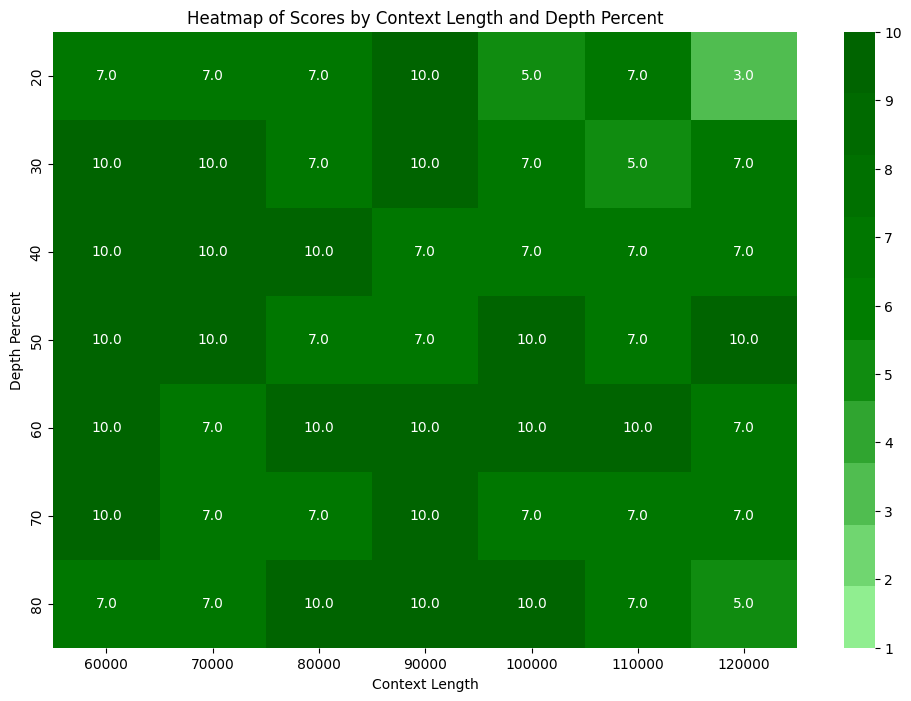

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv('results_qa_subset.csv')

# Assuming df is your DataFrame with the data
# Transform the scores
#df['score'] = df['score'].apply(lambda x: 9 if 7 <= x < 10 else (7 if 5 <= x < 7 else x))

# Create a pivot table with context_length as columns, depth_percent as rows, and score as values
heatmap_data = df.pivot_table(values='score', index='depth_percent', columns='context_length', aggfunc='mean')

# Define a custom colormap from light green to dark green
cmap = LinearSegmentedColormap.from_list(
    'custom_green', 
    ['lightgreen', 'green', 'darkgreen'], 
    N=10  # Assuming we have scores from 1 to 10
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=cmap, vmin=1, vmax=10)
plt.title('Heatmap of Scores by Context Length and Depth Percent')
plt.xlabel('Context Length')
plt.ylabel('Depth Percent')
plt.show()
